<a href="https://colab.research.google.com/github/vtd9/deep-learning/blob/explosion/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

CS 637, Spring 2022

Due 3/3/21

1) Implement an API to create a fully-connected multilayer perceptron (MLP) for a *k*-class classification problem.

2) Test this implementation on MNIST data.

Notation

*  `w`: weights
*  `b`: biases
*  `z`: aggregated values
*  `a`: activated values
*  `x`: input to a neural network
*  `yhat`: final output from the neural network (i.e., *after* softmax if applied)

In [1]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import time

# 1. API

## 1.1 Layer class

In [2]:
class Layer(object):
  '''
  Represents one layer of a multilayer perceptron (MLP).

  Initializes and updates parameter values, weights (w) and bias (b), for 
  aggregation within the layer.

  '''

  def __init__(self, in_dim=1, out_dim=1, activ_fun=None, init_with_normal=True, 
               mean=0, var=0.01, min=-0.1, max=0.1, activated=None):
    '''
    Constructs a new Layer object.

    Args:
     in_dim (int): Dimension of inputs to this layer
     out_dim (int): Dimension of outputs from this layer
     activ_fun (list or tuple): Container of functions from the Activation 
      class to apply to each layer
     init_with_normal (bool): True to initialize parameters by sampling from a 
      normal distribution, false to sample from a uniform distribution
     mean (float): Mean to use if initializing with a normal dist
     var (float): Variance to use if initializing with a normal dist
     min (float): Minimum bound to use if initializing with a uniform dist
     max (float): Maximum bound to use if initializing with a uniform dist
     activated (ndarray): Array to supply in special cases (i.e., input layer)
      to explicitly set the activation values before any data is passed through
      
    '''
    self.activ_fun = activ_fun
    self.w = None # Weights
    self.b = None # Bias
    self.z = None # Aggregations
    self.a = activated # Activations

    # Initialize layer's parameters if a non-input layer
    if activ_fun is not None:
      if init_with_normal:
        self.normal_init(out_dim, in_dim, mean, var) # Weights
        self.normal_init(out_dim, 1, mean, var, True) # Bias
      else:
        self.random_init(out_dim, in_dim, min, max) # Weights
        self.random_init(out_dim, 1, min, max, is_bias=True) # Bias

  def normal_init(self, out_dim, in_dim, mean=0.0, var=0.01, is_bias=False):
    '''
    Initialize parameters by sampling from a normal distribution.

    Args:


    '''
    # If variance not set, use Kaiming's initializaion with fan-in

    # Initialize weights or bias
    if is_bias:
      self.b = np.random.normal(mean, var**0.5, (out_dim, in_dim))
    else:
      self.w = np.random.normal(mean, var**0.5, (out_dim, in_dim))

  def random_init(self, out_dim, in_dim, min=-0.1, max=0.1, is_bias=False):
    '''
    Initialize parameters by sampling from a uniform distribution.

    Args:


    '''
    if is_bias:
      self.b = np.random.uniform(min, max, size=(out_dim, in_dim))
    else:
      self.w = np.random.uniform(min, max, size=(out_dim, in_dim))

  def zero_bias(self):
    '''
    Set layer biases to zero.

    '''
    self.b = np.zeros(self.b.shape)
  
  def forward(self, input, batch_size):
    '''
    Pass inputs forward through the layer.
    
    Args:
      input (ndarray): Feature values to pass through the model
      batch_size (int): Batch size of the input

    '''
    # Aggregate
    self.z = self.w @ input + self.b
    if np.isinf(self.z).any(): 
      print(self.z, self.w, self.b)
      raise ArithmeticError('Possibly exploding gradient')

    # Activate
    self.a = (self.activ_fun(self.z)).reshape(-1, batch_size)
  
  def adjust_weight(self, prev_a, grad_chain, lr, batch_size):
    '''
    Update weight values using the backpropagated gradient.
    
    Args:
      prev_a (ndarray): Activation from the previous layer
      grad_chain (ndarray): Backpropagated chain of derivatives so far
      lr: Learning rate

    '''
    # Normalize magnitude of adjustment with batch size
    self.w -= lr/batch_size * (grad_chain @ prev_a.T)
  
  def adjust_bias(self, grad_chain, lr, batch_size):
    '''
    Update bias values using the backpropagated gradient.

    Args:
      grad_chain (ndarray): Backpropagated chain of derivatives so far
      lr (float): Learning rate
      batch_size (int): Batch size

    '''
    # Derivative of an aggregate wrt bias (dz/db) = 1, so don't need the 
    # activation values of the previous layer
    self.b -= lr/batch_size * np.average(grad_chain, axis=1).reshape(-1, 1)

## 1.2 Perceptron class

In [3]:
class Perceptron(object):
  '''
  Represents a multi-layer perceptron (MLP) for processing input data. 
  
  Made of an aggregate of Layer objects that can be accessed from indexes,
  where 0 is the input layer, 1 is the first hidden layer, and so forth.

  '''

  def __init__(self, dims, activ_fns, loss_fn,
               init_with_normal=True, mean=0.0, var=0.01, min=-0.1, max=0.1):
    '''
    Constructs a new Perceptron object.

    Args:
      dims (list or tuple): Container of ints, each representing the 
        dimensionality of a layer at the same index. First integer should be
        the number of input features; last int is the number of output neurons.
      activ_fns (list or tuple): Container of methods from the Activation class 
      to apply on the hidden and output aggregations
      loss_fn: loss function to measure model performance
      init_with_normal (bool): True to initialize parameters by sampling from a 
        normal distribution, false to sample from a uniform one
      mean (float): Mean to use if initializing with a normal dist
      var (float): Variance to use if initializing with a normal dist
      min (float): Minimum bound to use if initializing with a uniform dist
      max (float): Minimum bound to use if initializing with a uniform dist

    '''
    # Ensure Perceptron has at least input and output layers
    assert len(dims) > 1

    # Ensure number of activation functions matches number of layers - 1
    assert len(dims) == len(activ_fns) + 1
    
    self.dims = dims
    self.n_layers = len(dims)
    self.activ_fns = activ_fns
    self.loss_fn = loss_fn
    self.reset(init_with_normal, mean, var, min, max) # Initialize parameters

  def reset(self, init_with_normal=True, mean=0.0, var=0.01, min=-0.1, max=0.1):  
    '''
    Initialize parameters in the MLP.

    Args:


    '''
    self.layers = [None] * len(self.dims)

    # For each layer besides the input layer, attach the appropriate dimensions, 
    # activation function, and initialization parameters
    for i in range(self.n_layers - 1):
      self.layers[i + 1] = Layer(
          in_dim=self.dims[i], out_dim=self.dims[i+1],
          activ_fun=self.activ_fns[i], 
          init_with_normal=init_with_normal,
           mean=mean, var=var, min=min, max=max)
  
  def zero_biases(self):
    '''
    Set all biases in the MLP to zero.

    '''
    for i in range(1, self.n_layers):
      self.layers[i].zero_bias()

  def __getitem__(self, layer_index):
    '''
    Retrieves reference to a layer in the MLP.

    Args:
      layer_index (int): Index of layer to access.

    Returns: 
      Layer object at layer_index

    '''
    return self.layers[layer_index]
  
  def forward(self, X, batch_size):
    '''
    Step forward through the MLP, aggregating the previous layer's values and
    then applying the chosen activation function.

    Args:
      X (ndarray): Input data to feed through the network
      batch_size (int): Batch size

    '''
    # Set the first layer (the input layer)'s "activation" to the input data
    self.layers[0] = Layer(activated=X)

    # Pass through each layer using inputs from previous layer
    for i, layer in enumerate(self.layers[1:], start=1):
      layer.forward(self.layers[i-1].a, batch_size)
  
  def backward(self, labels, lr, batch_size):
    '''
    Backpropagates from loss and adjust parameters after a forward pass.
    
    Args:
      labels (ndarray): True labels in a one-hot representation
      lr (float): Learning rate
      batch_size (int): Batch size
    
    '''
    # Calculate derivative of loss wrt logits
    grad_chain = self.loss_fn(self.layers[-1].a, labels, derive=True)

    for i in range(self.n_layers - 1, 0, -1):
      # Save current weight for dloss/da of the previous layer later
      prev_a = self.layers[i-1].a
      old_weight = self.layers[i].w

      # Adjust parameters
      self.layers[i].adjust_weight(prev_a, grad_chain, lr, batch_size)
      self.layers[i].adjust_bias(grad_chain, lr, batch_size)

      # Compute dloss/da of previous layer, multiply to current product
      grad_chain = (old_weight.T @ grad_chain) 

      # Compute dloss/dz of previous layer using elementwise multiplication
      if self.layers[i-1].activ_fun is not None:
        da_dz = self.layers[i-1].activ_fun(prev_a, derive=True)
      else: # Don't need to derive the input layer
        break
  
  def train(self, generator, lr, batch_size, train_mode=True):
    '''
    Train for a single epoch.

    Args:
      generator (generator): Generator to loop through one batch at a time
      lr (float): Learning rate
      train_mode (bool): True to backpropagate and update parameters
    
    Returns:
      Average loss (float), average accuracy (float)

    '''
    loss = 0.0
    acc = 0.0
    for i, (X, y) in enumerate(generator):
      self.forward(X, batch_size)

      if train_mode: # Adjust parameters only during training
        self.backward(y, lr, batch_size)

      # Update accumulated measures
      loss += self.loss_fn(self[-1].a, y)
      acc += Loss.accuracy(self[-1].a, y)

    # Average over the number of batches done
    return loss/(i+1), acc/(i+1)

## 1.3 Activation and loss functions

In [4]:
class Activation(object):
  '''
  Common activation functions used in a neural network.

  '''
  @staticmethod
  def relu(x, derive=False):
    '''
    Applies ReLU or its derivative on an input.
    
    Args:
      x (ndarray): Input data to apply ReLU on
      derive (bool): True to take derivative of ReLU wrt to X

    Returns:
      Activated or gradient value from ReLU.

    '''
    if not derive:
      return np.maximum(x, 0., x)
    else:
      return (x > 0).astype(int)
  
  @staticmethod
  def sigmoid(x, derive=False):
    '''
    Applies sigmoid or its deriative on an input.

    Args:
      x (ndarray): Input data to apply sigmoid on
       derive (bool): True to take derivative of sigmoid wrt to X

    Returns:
      Activated or gradient value from sigmoid.

    '''
    if not derive:
      return 1 / (1 + np.exp(-x))
    else: 
      return Activation.sigmoid(x) * (1-Activation.sigmoid(x))


  @staticmethod
  def softmax(x):
    '''
    Args:
      x (ndarray): Input data to apply softmax on

    Returns: 
      Probability values for a k-class classification so the sum of a 
      given example over all classes = 1.0
      
    '''
    # Update from using a naive implementation - prevent numerical overflows
    # by using shifting trick as opposed to np.exp(x)/np.sum(np.exp(x), axis=0)
    shift = np.max(x)
    exp_x = np.exp(x - shift)
    return exp_x/np.sum(exp_x, axis=0)

In [5]:
class Loss(object):
  '''
  Common loss functions used in a neural network.

  '''

  @staticmethod
  def cross_entropy(yhat, y, epsilon=1e-5, derive=False):
    '''
    Computes the cross-entropy loss or its gradient with respect to logits for 
    a batch of predictions.

    Args:
      yhat (ndarray): Outputs (after activation) from a MLP
      y (ndarray): Actual labels to compare output with
      epsilon (float): Small positive value to prevent taking log of 0
      derive (bool): True to return derivative wrt logits

    Returns:
      Cross-entropy loss value or its derivative wrt logits

    '''
    if not derive:
      # Squash for each example by summing before averaging - 
      # erroneously many zeros otherwise
      return np.average(np.sum(-y * np.log(yhat + epsilon), axis=0))
    else:
      return yhat - y

  @staticmethod
  def hinge_loss(yhat, y, margin=1.0, derive=False):
    '''
    Computes the hinge loss or its derivative for a batch of predictions.

    Args:
      yhat (ndarray): Outputs (after activation) from a MLP
      y (ndarray): Actual labels to compare output with
      margin (float): Margin for target class value to overtake
      derive (bool): True to return derivative

    Returns:
      Hinge loss value or its derivative

    '''
    # Output of the target class for each example
    # Repeat so same value going down row to get same shape as yhat
    y_target = np.sum(np.where(y == 1, yhat, 0), axis=0)

    # Get distances from outputs at indexes != target class
    # Add margin to elements at indexes != target class
    dist = np.where(y == 1, 0, yhat - y_target + margin)

    if not derive:
      # Get the positive differences over each example (zero-threshold)
      pos_per_example = np.where(dist > 0, dist, 0)

      # Sum over each example, average over all batches
      return np.sum(np.sum(pos_per_example, axis=0))
    else:
      return
  
  @staticmethod
  def accuracy(yhat, y, y_one_hot=True):
    '''
    Computes the accuracy for a batch of outputs.

    Args:
      yhat (ndarray): Outputs (after activation) from a MLP
      y (ndarray): Actual labels to compare output with
      y_one_hot: True if y given in one-hot form, false if given as a list 
        of correct indexes

    Returns:
      Accuracy of a given output against its true values

    '''
    # Prediction class is the one with max predicted probability in each example
    yhat_choices = np.argmax(yhat, axis=0)

    # Reverse the actual labels' representation as one-hot for easier comparison
    if y_one_hot:
      y = Utility.reverse_one_hot(y)

    # Compute the average accuracy of the batch
    return np.average(yhat_choices == y)

In [6]:
# TEMP: hinge loss bumbling
yhat = np.random.normal(size=(4,3)).T
y = np.zeros((4, 3)).T
y[0, 0] = 1
y[2, 1] = 1
y[1, 2] = 1
y[0, 3] = 1
yhat, y

(array([[ 1.58109676, -0.82070111,  1.35998506,  1.02665171],
        [-1.02326697,  1.56572325, -0.55458617, -1.70785564],
        [ 0.60870623, -0.53913148,  0.39781522, -1.54012685]]),
 array([[1., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]]))

In [7]:
# TEMP
y_target = np.sum(np.where(y == 1, yhat, 0), axis=0)
dist = np.where(y == 1, 0, yhat - y_target + 1.)
maybe_deriv = np.where(y == 1, np.sum(dist > 0, axis=0), dist > 0)
dist, maybe_deriv

(array([[ 0.        ,  0.71843037,  2.91457122,  0.        ],
        [-1.60436374,  3.10485473,  0.        , -1.73450735],
        [ 0.02760947,  0.        ,  1.95240139, -1.56677856]]),
 array([[1, 1, 1, 0],
        [0, 1, 2, 0],
        [1, 2, 1, 0]]))

## 1.4 Utilities class

In [21]:
class Utility(object):
  '''
  Miscellaneous methods for training and plotting.

  '''

  @staticmethod
  def train_and_validate(mlp, dataset, lr, epochs, batch_size,
                         shuffle_every_epoch=True, verbose=True):
    '''
    Train and validate in parallel over one or more epochs.

    Args:
      mlp: Perceptron object to train
      dataset: Dataset object to pull features and labels from
      lr (float): Learning rate
      epochs (int): Number of epochs to train in
      batch_size (int): Batch size
      shuffle_every_epoch (bool): True to reshuffle training and validation
        data within their divisions when regenerating the batches
      verbose (bool): True to print loss and accuracy values after each epoch

    Returns:

    
    '''
    assert (epochs > 0)
    train_loss = np.empty(epochs)
    train_acc = np.empty(epochs)
    valid_loss = np.empty(epochs)
    valid_acc = np.empty(epochs)
    start_time = time.time()
    if verbose:
      print('Epoch \tTrain_loss \tTrain_acc \tValid_loss \tValid_acc')

    for epoch in range(epochs):
      # Make iterators
      train_iter = dataset.make_batches(batch_size, group='train', 
                                        shuffle_again=shuffle_every_epoch)
      valid_iter = dataset.make_batches(batch_size, group='valid',
                                        shuffle_again=shuffle_every_epoch)

      # Train and validate - validate "previous" model before updating
      valid_loss[epoch], valid_acc[epoch] = mlp.train(valid_iter, lr=lr,
                                                      batch_size=batch_size,
                                                      train_mode=False)
      train_loss[epoch], train_acc[epoch] = mlp.train(train_iter, lr=lr,
                                                      batch_size=batch_size,
                                                      train_mode=True)
      
      # If set to print out info as executing
      if verbose:
        print('{} \t{:9.3f} \t{:9.3f} \t {:9.3f} \t{:9.3f}'.format(
            epoch, train_loss[epoch], train_acc[epoch], 
            valid_loss[epoch], valid_acc[epoch]))

    # Print amount of time taken
    print('Time elapsed (s): {:2.1f}\n'.format(time.time() - start_time))


    return train_loss, train_acc, valid_loss, valid_acc
  
  @staticmethod
  def make_one_hot(y):
    '''
    Make a traditional container of labels into a one-hot representation.
    
    Args:
      y (list or tuple): Container of labels to convert

    Returns:
      Transformed array in one-hot representation
    
    '''
    transformed = np.zeros((y.size, y.max() + 1))
    transformed[np.arange(y.size), y] = 1
    return transformed.T

  @staticmethod
  def reverse_one_hot(y):
    '''
    Convert a one-hot array back to a simple list of indices.

    Args:
      y (ndarray): Array to convert
    
    Returns:
      Transformed array as a sequence of indexes

    '''
    return np.argmax(y, axis=0)

  @staticmethod
  def plot_images(dataset, y, num_images=3):
    '''
    Plot using the flattened representation of a square image in input X.

    Args:

    
    '''
    # Get random sample of dataset
    indexes = np.random.randint(0, dataset.X.shape[-1], num_images)

    # Display data as images
    width = int(dataset.X.shape[0]**0.5)

    for i in indexes:  
      plt.subplot(330 + 1 + i)
      plt.axis('off')
      plt.imshow(dataset.X[:, i+i].reshape(width, width), 
                 cmap=plt.get_cmap('gray'))
      
      # Title each image with its true label
      plt.title([Utility.reverse_one_hot(y[:, i+i])])

      # TItle ach image with its predicted label, if any
  
  @staticmethod
  def plot_results(results, labels=None, fmts=None, xlabel='Epoch', ylabel='',
                   ymax=None, title=''):
    
    '''
    Plot one or more results

    Args:
      results (list or tuple): Container of ndarray results to plot
      labels (list or tuple): Container of strings, each a label corresponding
        to each result to be displayed in the legend
      fmts (list or tuple): Container of strings matching the matplotlib's
        line, color, and marker styles. None to use default
      xlabel (str): Label on x-axis
      ylabel (str): Label on y-axis
      ymax (float): Maximum bound to set y-axis to. None to use automatic
        settings
      title (str): Title of plot

    '''
    # Account for arguments not given
    if labels is None: 
      labels = (str(_) for _ in range(len(results)))
    else:
      assert len(results) == len(labels)

    if fmts is None:
      fmts = ('' for _ in range(len(results)))
    else:
      assert len(results) == len(fmts)

    # Plot each set of results with its corresponding label and format
    for result, label, fmt in zip(results, labels, fmts):
      plt.plot(np.arange(result.shape[0]), result, fmt, label=label)

    # Parameters affecting entire plot
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)  
    if ymax is not None:
      plt.ylim(0, ymax)

## 1.5 Dataset class

In [9]:
class Dataset(object):
  '''
  Represents a set of data with methods to reshape, split, and train.

  '''
  def __init__(self, X, y, make_y_one_hot=True):
    '''
    Constructs a Dataset object.
    
    Args:
      X (ndarray): Input data
      y (ndarray): Labels corresponding to input data
      make_y_one_hot (bool): True to convert the labels into a one-hot 
        representation, if not done already; false to skip this step

    '''
    self.X = X
    self.y = y
    self.X_train = None
    self.y_train = None
    self.X_valid = None
    self.y_valid = None
    self.X_test = None
    self.y_test = None

    if make_y_one_hot:
      self.y = Utility.make_one_hot(self.y)

  def shape(self, features, categories, flatten_X=True):
    '''
    Reshapes the input and output data.

    Args:
      features: Number of features in the input data. Set to width of a 2D image
        if it will be flattened.
      categories: Number of categories in the classification problem
      flatten_X: True to flatten a 2D image into a 1D array

    '''
    if flatten_X: 
      self.X = self.X.reshape(-1, features*features).T
    else:
      self.X = self.X.reshape(features, -1)
    self.y = self.y.reshape(categories, -1)

  def shuffle(self):
    '''
    Shuffles both X and y together in the dataset.

    '''
    assert self.X.shape[-1] == self.y.shape[-1]
    shuffled_indexes = np.random.permutation(self.X.shape[-1])
    self.X = self.X[:, shuffled_indexes]
    self.y = self.y[:, shuffled_indexes]

  def divide(self, p_train=70, p_valid=15, p_test=15):
    '''
    Divide the loaded data into sets for training, validation, and testing.

    Args:
      p_train (int): Percentage of data to allot for training
      p_valid (int): Percentage of data to allot for validation
      p_test (int): Percentage of data to allot for testing

    '''
    if (p_train + p_valid + p_test != 100):
      raise ValueError('Error: percentages don''t sum up to 100!')
    n_train = int(p_train * 0.01 * self.X.shape[-1])
    n_valid = int(p_valid * 0.01 * self.X.shape[-1])
    n_test = int(p_test * 0.01 * self.X.shape[-1])

    # If missing a few examples from cutoffs, add to training set
    test_diff = self.X.shape[-1] - (n_train + n_valid + n_test)
    if test_diff > 0:
      n_train += test_diff

    # Define groups
    self.X_train = self.X[:, 0:n_train]
    self.y_train = self.y[:, 0:n_train]
    self.X_valid = self.X[:, n_train:(n_train + n_valid)]
    self.y_valid = self.y[:, n_train:(n_train + n_valid)]
    self.X_test = self.X[:, (n_train + n_valid): ]
    self.y_test = self.y[:, (n_train + n_valid): ]
    
  def make_batches(self, batch_size, group='train', scale_X=True,
                   shuffle_again=True):
    '''
    Make batches given a specified size and a selected group.

    Args: 
      batch_size (int): Batch size to divide data into
      group (str): Either train, valid, or test to select group
      scale_X (bool): True to rescale data to be between 0 and 1
      shuffle_again (bool): True to shuffle data within its group when 
        a new set of batches is made

    Returns:
      Generator of batches in the specified size from the specified group.

    '''
    # Get the training, testing, or validation group:
    if group == 'train':
      X_select, y_select = self.X_train, self.y_train
    elif group == 'valid':
      X_select, y_select = self.X_valid, self.y_valid
    elif group == 'test':
      X_select, y_select = self.X_test, self.y_test
    else:
      raise ValueError('Incorrect argument for group! Choose between train, '
                       'validate, or test.')

    # Shuffle within the group, if specified
    if shuffle_again:
      shuffled_indexes = np.random.permutation(X_select.shape[-1])
      X_select = X_select[:, shuffled_indexes]
      y_select = y_select[:, shuffled_indexes]

    # Make generators for the features and labels of the selected set
    for i in range(0, X_select.shape[-1], batch_size):
      if scale_X: # Rescale X to have values between 0 and 1
        X_scaled = np.linalg.norm(X_select[:, i:i+batch_size])
        yield X_select[:, i:i+batch_size]/X_scaled, y_select[:, i:i+batch_size]
      else:
        yield X_select[:, i:i+batch_size], y_select[:, i:i+batch_size]

# 2. Testing the API

## 2.1 Import the MNIST dataset
*   Permitted to use outside packages for downloading MNIST data, so use `keras`.
*   Merge existing training and test sets and resplit, since splitting must be done by this homework's API.



In [10]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [11]:
mnist_all_X = np.concatenate((train_X, test_X), axis=0)
mnist_all_y = np.concatenate((train_y, test_y), axis=0)
print('MNIST features reshaped:', mnist_all_X.shape, 
      '\nMNIST labels reshaped:', mnist_all_y.shape)

MNIST features reshaped: (70000, 28, 28) 
MNIST labels reshaped: (70000,)


## 2.2 Preprocessing

In [12]:
# Make a Dataset object
mnist_set = Dataset(mnist_all_X, mnist_all_y, True)

# Reshape the data
width = 28
categories = 10
mnist_set.shape(width, categories, True)
print("Feature and label shapes:", mnist_set.X.shape, mnist_set.y.shape)

# Shuffle the data
# plot first __ before shuffling
mnist_set.shuffle()
# plot first __ after to prove it's shuffled?

# Divide the data
mnist_set.divide()
print('Splits on training, validation, & testing:', 
      mnist_set.X_train.shape, mnist_set.X_valid.shape, mnist_set.X_test.shape)

Feature and label shapes: (784, 70000) (10, 70000)
Splits on training, validation, & testing: (784, 49000) (784, 10500) (784, 10500)


## Training and validation

### Varying the learning rate

In [20]:
# Make a generic neural network with two hidden layers
p = Perceptron((width*width, 64, 32, 10),
               (Activation.relu, Activation.relu, Activation.softmax),
               Loss.cross_entropy, var=0.01)
lrs = (0.2, 0.1, 0.05, 0.01) # Different learning rates to test
epochs = 15
lr_results = []
for lr in lrs:
  lr_results.append(Utility.train_and_validate(p, mnist_set, lr, epochs, 100))
  p.reset()

Epoch 	Train_loss 	Train_acc 	Valid_loss 	Valid_acc
0 	    2.303 	    0.106 	     2.307 	    0.107
1 	    2.298 	    0.113 	     2.299 	    0.111
2 	    2.283 	    0.131 	     2.294 	    0.111
3 	    2.115 	    0.218 	     2.259 	    0.194
4 	    1.640 	    0.435 	     1.883 	    0.324
5 	    1.207 	    0.580 	     1.387 	    0.524
6 	    0.912 	    0.706 	     1.075 	    0.648
7 	    0.746 	    0.759 	     0.819 	    0.733
8 	    0.684 	    0.783 	     0.727 	    0.765
9 	    0.641 	    0.801 	     0.685 	    0.778
10 	    0.600 	    0.819 	     0.639 	    0.799
11 	    0.559 	    0.833 	     0.599 	    0.814
12 	    0.525 	    0.845 	     0.553 	    0.829
13 	    0.498 	    0.855 	     0.530 	    0.841
14 	    0.473 	    0.863 	     0.498 	    0.855
Time elapsed (s): 28.3
Epoch 	Train_loss 	Train_acc 	Valid_loss 	Valid_acc
0 	    2.304 	    0.105 	     2.313 	    0.090
1 	    2.299 	    0.113 	     2.300 	    0.111
2 	    2.297 	    0.113 	     2.298 	    0.111
3 	    2.293 	    0.11

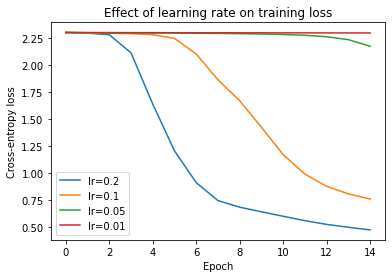

In [23]:
# Plot training loss for the different learning rates used
Utility.plot_results([_[0] for _ in lr_results],
                     labels=['lr=' + str(lr) for lr in lrs],
                     ylabel='Cross-entropy loss',
                     title='Effect of learning rate on training loss')

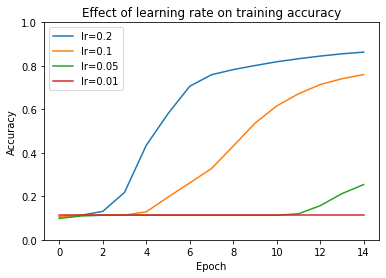

In [24]:
# Plot training accuracy for the different learning rates used
Utility.plot_results([_[1] for _ in lr_results],
                     labels=['lr=' + str(lr) for lr in lrs],
                     ylabel='Accuracy', ymax=1.0,
                     title='Effect of learning rate on training accuracy')

### Changing the architecture

*   Number of hidden layers
*   Number of neurons per layer



In [ ]:
# MLP with 2 hidden layers
p = Perceptron((width*width, 128, 64, 10),
                  (Activation.relu, Activation.relu, Activation.softmax),
                  Loss.cross_entropy, batch_size=100)

# Run, store results in variable
r2 = Utility.train_validate(p, mnist_set, lr=5e-4, epochs=25, verbose=True)

# Plot results
Utility.plot_results(r2[0], r2[1], r2[2], r2[3],
                     labels=('Test loss', 'Test accuracy', 'Validation loss', 
                             'Validation accuracy'),
                     fmts=('', '', 'o', 'o'), ymax=1.0,
                     title='MLP with two hidden layers')

In [ ]:
# MLP with 3 hidden layers
p = Perceptron((width*width, 128, 64, 32, 10),
               (Activation.relu, Activation.relu, Activation.relu, Activation.softmax),
               Loss.cross_entropy, batch_size=100)
r3 = Utility.train_validate(p, mnist_set, lr=5e-4, epochs=25, verbose=True)
Utility.plot_results(r3[0], r3[1], r3[2], r3[3],
                     labels=('Test loss', 'Test accuracy', 'Validation loss', 
                             'Validation accuracy'),
                     fmts=('', '', 'o', 'o'), ymax=1.0,
                     title='MLP with three hidden layers')

In [ ]:
# MLP with 2 hidden layers, fewer neurons
mlp = Perceptron((width*width, 16, 8, 10),
                  (Activation.relu, Activation.relu, Activation.softmax),
                  Loss.cross_entropy, batch_size=100)
r2b = Utility.train_validate(mlp, mnist_set, lr=2e-3, epochs=25, verbose=True)
Utility.plot_results(r2b[0], r2b[1], r2b[2], r2b[3],
                     labels=('Test loss', 'Test accuracy', 'Validation loss', 
                             'Validation accuracy'),
                     fmts=('', '', 'o', 'o'), ymax=1.0,
                     title='MLP with two hidden layers, fewer neurons')

MLP with fewer neurons in hidden layers is more efficient to train but results in more loss and less accuracy. 

### Selecting activation functions

### Changing loss function

### Changing how parameters are initialized

# Miscellaneous tasks

Toy tests to manually check basic functionality

Hinge loss examples on 1/20/22 lecture:

In [ ]:
# 3-class classification example
ex1 = np.array([-3.7, 5, 7]).T
print('Target class is 3, loss={:0.1f} \tif 2, {:0.1f} \tif 1, {:0.1f}'.format(
    Loss.hinge_loss(ex1, np.array([0, 0, 1]).T),
    Loss.hinge_loss(ex1, np.array([0, 1, 0]).T),
    Loss.hinge_loss(ex1, np.array([1, 0, 0]).T)))

Target class is 3, loss=0.0 	if 2, 3.0 	if 1, 21.4


In [ ]:
# 4-class classification example
ex2 = np.array([2.5, 2.0, 2.7, 1.7]).T
print('Target class is 2: {:0.1f}'.format(
    Loss.hinge_loss(ex2, np.array([0, 1, 0, 0]).T)))

Target class is 2: 3.9


Compute accuracy on two examples, one correct and one not:

In [ ]:
yhat = np.array(((0.2, 0.5, 0.3), (0.7, 0.2, 0.1))).T
y = np.array(((0, 1, 0), (0, 1, 0))).T
Loss.accuracy(yhat, y)

0.5

Informal problem given at the end of class, 1/25/22:

In [ ]:
p = Perceptron((4, 3, 2, 4), 
               (Activation.relu, Activation.sigmoid, Activation.softmax), 
               Loss.cross_entropy, init_with_normal=True)
p[1].w = np.array([[1.,0,0,0], [0,1,0,0], [0,0,1,0]])
p[2].w = np.array([[1.,0,0], [0,1,0]])
p[3].w = np.array([[1.,0], [0,1], [0,0], [0,0]])
p.zero_biases()

# Check forward path
p.forward(np.array([1, 0, 1, 0]).reshape(-1, 1), batch_size=1)
for i in range(1, len(p.dims)):
  print('Layer', i, '\nz =\n', p[i].z, '\na =\n', p[i].a, '\n')

In [ ]:
# Check backpropagation
y = np.array([0., 1., 0., 0.]).reshape(-1, 1) # Dummy one-hot label
print('p[1].w before backprop\n', p[1].w)
p.backward(y, lr=0.5, batch_size=1)
print('p[1].w after backprop\n', p[1].w)

Activation.softmax(p[3].w @ p[2].a + p[3].b)

p[1].w before backprop
 [[1.04421637 0.         0.04421637 0.        ]
 [0.         1.         0.         0.        ]
 [0.03964693 0.         1.03964693 0.        ]]
layer 1
p[1].w after backprop
 [[1.14514486 0.         0.14514486 0.        ]
 [0.         1.         0.         0.        ]
 [0.09621592 0.         1.09621592 0.        ]]


array([[0.05991671],
       [0.8446309 ],
       [0.04772619],
       [0.04772619]])